# Notebook — MNIST classification with Keras (SGD + cross-entropy)

In the previous notebook we trained a small network *from scratch* in NumPy and treated MNIST as a **regression** problem.

In this notebook we do the **standard classification approach**:

- **Input:** flattened \(28	imes 28\) image \(ightarrow 784\)-dimensional vector  
- **Model:** 1 hidden layer with sigmoid activation  
- **Output:** 10 classes with **softmax**  
- **Loss:** **categorical cross-entropy**  
- **Optimizer:** **SGD** (stochastic gradient descent)

We will:
1. Load MNIST
2. Normalize features
3. One-hot encode labels
4. Train with **full-batch** SGD (batch size = training set size) to mirror the math in the lecture notes
5. Plot loss curves + confusion matrices

> **Teaching note:** Full-batch training is used here for clarity and reproducibility.  
> In practice, mini-batches (e.g. 64–256) are usually faster and generalize better.


In [1]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (12, 6)


2025-12-15 12:34:17.827278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 12:34:17.853067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-15 12:34:17.853086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-15 12:34:17.853730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-15 12:34:17.857964: I tensorflow/core/platform/cpu_feature_guar

## 1) Helper: confusion matrix (row-normalized)

A confusion matrix shows, for each true digit (row), how the predicted digits (columns) are distributed.

We normalize each row so that:
- each row sums to 1
- diagonal entries represent per-class accuracy


In [2]:
def get_confusion_matrix(pred, true, num_classes=10):
    """Row-normalized confusion matrix.

    Parameters
    ----------
    pred : (N,) array of predicted labels in {0..9}
    true : (N,) array of true labels in {0..9}
    num_classes : int

    Returns
    -------
    cm : (10, 10) array
         Row-normalized confusion matrix, cm[i,j] = P(pred=j | true=i)
    """
    cm = np.zeros((num_classes, num_classes), dtype=np.float32)

    for label in range(num_classes):
        mask = (true == label)
        if np.sum(mask) == 0:
            continue
        counts = np.bincount(pred[mask], minlength=num_classes)
        cm[label, :] = counts / counts.sum()

    return cm


## 2) Load MNIST

TensorFlow provides MNIST already split into training and test sets.

- `X_train` has shape `(60000, 28, 28)`
- `X_test` has shape `(10000, 28, 28)`


In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (60000, 28, 28) y_train: (60000,)
X_test : (10000, 28, 28) y_test : (10000,)


## 3) Preprocess: flatten + normalize

We convert each image into a vector of length 784.

Then we normalize using the **training** mean and std:
\[
X \leftarrow rac{X - \mu_{	ext{train}}}{\sigma_{	ext{train}}}.
\]

Why use train statistics for test/validation?
- To avoid leaking information from the test set into training.


In [4]:
# Flatten: (N, 28, 28) -> (N, 784)
X_train = X_train.reshape(-1, 28 * 28).astype("float32")
X_test  = X_test.reshape(-1, 28 * 28).astype("float32")

# Normalize using TRAIN statistics
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / (std + 1e-8)
X_test  = (X_test  - mean) / (std + 1e-8)

print("Flattened X_train:", X_train.shape)
print("Mean/std used:", mean, std)


Flattened X_train: (60000, 784)
Mean/std used: 33.318447 78.567444


## 4) Labels: one-hot encoding

For softmax + categorical cross-entropy we use **one-hot** labels:

- digit 3 → \([0,0,0,1,0,0,0,0,0,0]\)

This produces:
- `y_train`: shape `(N, 10)`


In [5]:
y_train_oh = to_categorical(y_train, 10)
y_test_oh  = to_categorical(y_test, 10)

print("y_train one-hot:", y_train_oh.shape)


y_train one-hot: (60000, 10)


## 5) Train/validation split

We hold out 20% of the training data for validation.

Why validation?
- to detect overfitting
- to tune hyperparameters without touching the test set


In [6]:
X_train, X_val, y_train_oh, y_val_oh = train_test_split(
    X_train, y_train_oh, test_size=0.2, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train_oh.shape)
print("Val  :", X_val.shape,   y_val_oh.shape)


Train: (48000, 784) (48000, 10)
Val  : (12000, 784) (12000, 10)


## 6) Define the model

Architecture (very close to the NumPy version, but now in classification form):

- Dense(21, sigmoid)
- Dense(10, softmax)

Softmax outputs a probability vector:
\[
\hat p \in \mathbb{R}^{10},\quad \sum_k \hat p_k = 1.
\]


In [7]:
model = Sequential([
    Dense(21, activation="sigmoid", input_shape=(28 * 28,)),  # hidden layer
    Dense(10, activation="softmax")                           # 10-class output
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                16485     
                                                                 
 dense_1 (Dense)             (None, 10)                220       
                                                                 
Total params: 16705 (65.25 KB)
Trainable params: 16705 (65.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-12-15 12:34:30.965862: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 7) Compile: SGD + categorical cross-entropy

- **SGD** update rule (conceptually):
\[
	heta \leftarrow 	heta - \eta 
abla_	heta \mathcal{L}.
\]

- **Categorical cross-entropy** for one-hot targets:
\[
\mathcal{L} = -rac{1}{N}\sum_{i=1}^N \sum_{k=1}^{10} y_{i,k}\log(\hat p_{i,k}).
\]


In [8]:
eta = 1.0
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Learning rate:", eta)


Learning rate: 1.0


## 8) Train (full-batch)

To mirror the math in the lecture notes, we use:

- `batch_size = len(X_train)` → one gradient update per epoch

We train for 500 epochs to see smooth learning curves.


In [9]:
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=500,
    batch_size=len(X_train),   # full batch
    verbose=2
)


Epoch 1/500
1/1 - 0s - loss: 2.4623 - accuracy: 0.0851 - val_loss: 2.0429 - val_accuracy: 0.3439 - 500ms/epoch - 500ms/step
Epoch 2/500
1/1 - 0s - loss: 2.0465 - accuracy: 0.3407 - val_loss: 1.7999 - val_accuracy: 0.5338 - 50ms/epoch - 50ms/step
Epoch 3/500
1/1 - 0s - loss: 1.7987 - accuracy: 0.5313 - val_loss: 1.6459 - val_accuracy: 0.5948 - 52ms/epoch - 52ms/step
Epoch 4/500
1/1 - 0s - loss: 1.6451 - accuracy: 0.5937 - val_loss: 1.5485 - val_accuracy: 0.6187 - 54ms/epoch - 54ms/step
Epoch 5/500
1/1 - 0s - loss: 1.5474 - accuracy: 0.6164 - val_loss: 1.4532 - val_accuracy: 0.7093 - 51ms/epoch - 51ms/step
Epoch 6/500
1/1 - 0s - loss: 1.4527 - accuracy: 0.7077 - val_loss: 1.3484 - val_accuracy: 0.6892 - 48ms/epoch - 48ms/step
Epoch 7/500
1/1 - 0s - loss: 1.3473 - accuracy: 0.6940 - val_loss: 1.2629 - val_accuracy: 0.7681 - 51ms/epoch - 51ms/step
Epoch 8/500
1/1 - 0s - loss: 1.2626 - accuracy: 0.7665 - val_loss: 1.1806 - val_accuracy: 0.7505 - 53ms/epoch - 53ms/step
Epoch 9/500
1/1 - 0s -

## 9) Evaluate + collect curves

We extract:
- training/validation loss
- training/validation accuracy


In [10]:
train_loss, train_acc = model.evaluate(X_train, y_train_oh, verbose=0)
val_loss, val_acc     = model.evaluate(X_val,   y_val_oh,   verbose=0)

print(f"Final train: loss={train_loss:.4f}, acc={train_acc:.4f}")
print(f"Final val  : loss={val_loss:.4f}, acc={val_acc:.4f}")

training_loss     = history.history["loss"]
validation_loss   = history.history["val_loss"]
training_accuracy = np.array(history.history["accuracy"])
validation_accuracy = np.array(history.history["val_accuracy"])


Final train: loss=0.1813, acc=0.9499
Final val  : loss=0.2086, acc=0.9394


## 10) Predictions + confusion matrices

We convert softmax outputs to predicted labels using:
\[
\hat y = rg\max_k \hat p_k.
\]


In [11]:
# Predicted labels (argmax over softmax probabilities)
y_train_pred = np.argmax(model.predict(X_train, verbose=0), axis=1)
y_val_pred   = np.argmax(model.predict(X_val,   verbose=0), axis=1)

# True labels from one-hot
y_train_true = np.argmax(y_train_oh, axis=1)
y_val_true   = np.argmax(y_val_oh,   axis=1)

conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_val   = get_confusion_matrix(y_val_pred,   y_val_true)

# One simple "accuracy from confusion matrix" summary:
# mean diagonal = average per-class accuracy (balanced accuracy)
acc_train_bal = 100 * np.mean(np.diag(conf_mat_train))
acc_val_bal   = 100 * np.mean(np.diag(conf_mat_val))

print(f"Balanced acc (train): {acc_train_bal:.2f}%")
print(f"Balanced acc (val)  : {acc_val_bal:.2f}%")


Balanced acc (train): 94.93%
Balanced acc (val)  : 93.87%


## 11) Plot: learning curves + confusion matrices

Left:
- training vs validation loss over epochs

Middle/Right:
- row-normalized confusion matrices  
  (row = true digit, col = predicted digit)


Saved: ./fig_mnist_categorical_cross_entropy.png


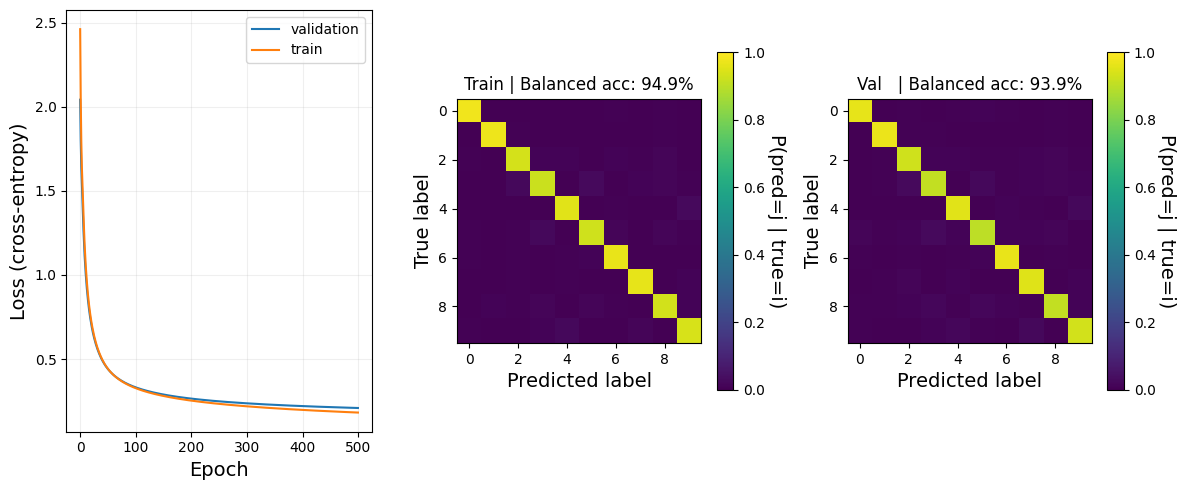

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
FontSize = 14

# --- Loss curves ---
ax[0].plot(validation_loss, label="validation")
ax[0].plot(training_loss, label="train")
ax[0].set_ylabel("Loss (cross-entropy)", fontsize=FontSize)
ax[0].set_xlabel("Epoch", fontsize=FontSize)
ax[0].grid(alpha=0.2)
ax[0].legend()

# --- Confusion matrices ---
im1 = ax[1].imshow(conf_mat_train, cmap="viridis", vmin=0, vmax=1)
im2 = ax[2].imshow(conf_mat_val,   cmap="viridis", vmin=0, vmax=1)

ax[1].set_title(f"Train | Balanced acc: {acc_train_bal:.1f}%")
ax[2].set_title(f"Val   | Balanced acc: {acc_val_bal:.1f}%")

ax[1].set_xlabel("Predicted label", fontsize=FontSize)
ax[1].set_ylabel("True label", fontsize=FontSize)
ax[2].set_xlabel("Predicted label", fontsize=FontSize)
ax[2].set_ylabel("True label", fontsize=FontSize)

for k in [1, 2]:
    ax[k].set_xticks([0, 2, 4, 6, 8])
    ax[k].set_yticks([0, 2, 4, 6, 8])

cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.8)
cbar1.ax.set_ylabel("P(pred=j | true=i)", rotation=270, labelpad=15, fontsize=FontSize)

cbar2 = fig.colorbar(im2, ax=ax[2], shrink=0.8)
cbar2.ax.set_ylabel("P(pred=j | true=i)", rotation=270, labelpad=15, fontsize=FontSize)

plt.tight_layout()

out_path = "./fig_mnist_categorical_cross_entropy.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved:", out_path)

plt.show()


## 12) Optional experiment: compare learning rates

The original script included a loop over different learning rates.

Below is a **safe template** if you want to test multiple learning rates.
Important: You should create a **fresh model** inside the loop, otherwise you keep training the same model repeatedly.

(Leave commented unless you want to run it.)


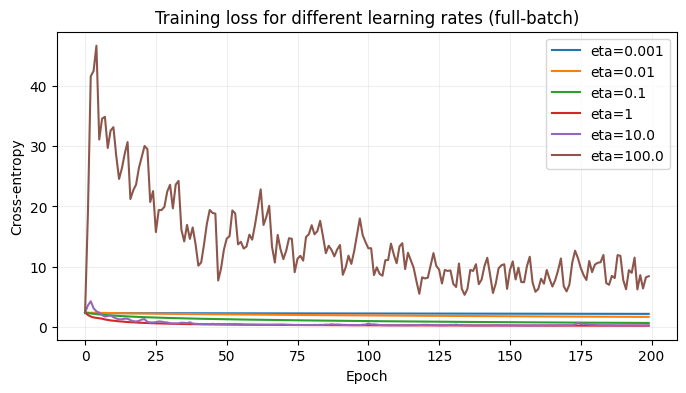

In [16]:
# OPTIONAL: compare learning rates
learning_rates = [1e-3, 1e-2, 1e-1, 1, 10.0, 100.0]
histories = {}
for eta in learning_rates:
     # IMPORTANT: create a fresh model each time
     model_lr = Sequential([
         Dense(21, activation="sigmoid", input_shape=(28 * 28,)),
         Dense(10, activation="softmax")
     ])

     opt = tf.keras.optimizers.SGD(learning_rate=eta)
     model_lr.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
#
     hist = model_lr.fit(
         X_train, y_train_oh,
         validation_data=(X_val, y_val_oh),
         epochs=200,
         batch_size=len(X_train),
         verbose=0
     )

     histories[eta] = hist.history

# Plot loss curves for each learning rate
plt.figure(figsize=(8,4))
for eta, h in histories.items():
     plt.plot(h["loss"], label=f"eta={eta}")
plt.title("Training loss for different learning rates (full-batch)")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy")
plt.grid(alpha=0.2)
plt.legend()
plt.show()


1. **Softmax + cross-entropy** is the standard setup for multi-class classification.
2. The training loop is handled by Keras, but conceptually it still does:
   - forward pass
   - loss computation
   - backpropagation (autodiff)
   - SGD parameter update
3. Confusion matrices give *much more detail* than accuracy alone.

### Exercises
- Change the hidden layer size (21 → 50 → 200) and compare learning curves.
- Replace sigmoid with ReLU and compare convergence.
- Use mini-batches: `batch_size=128`.
- Evaluate on the test set and plot a test confusion matrix.
